Poetry VAE: A Variational Autoencoder for Diverse Poetry Generation
==================================================================
This implementation creates a VAE architecture for generating diverse poetry
using the Poetry Foundation dataset from Kaggle.

The code includes:
1. Data downloading and preprocessing
2. VAE model definition
3. Training loop with visualization
4. Generation and evaluation utilities
5. Google Drive integration for Colab

Import Libraries

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from collections import Counter
import re
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import kagglehub
from google.colab import drive
import shutil
import nltk
nltk.download('punkt_tab')

Set random seeds for reproducibility

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Parameters

In [ ]:
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
LATENT_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.5
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 3e-4
MAX_SEQUENCE_LENGTH = 150  # Maximum sequence length for poems
MIN_WORD_FREQ = 5  # Minimum word frequency to include in vocabulary
BETA = 1.0  # Beta parameter for KL divergence weight in loss function
TEACHER_FORCING_RATIO = 0.5  # Probability of using teacher forcing


Create directory structure

In [ ]:
def create_directories():
    """Create necessary directories"""
    os.makedirs('data', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    os.makedirs('outputs', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Mount Google Drive for saving models
    drive.mount('/content/drive', force_remount=True)
    os.makedirs('/content/drive/MyDrive/poetry_vae', exist_ok=True)

    print("Directory structure created.")


Data Downloading and Preprocessing

In [ ]:
def download_dataset():
    """Download the Poetry Foundation dataset from Kaggle"""
    path = kagglehub.dataset_download("tgdivy/poetry-foundation-poems")
    print(f"Dataset downloaded to: {path}")
    return path

def extract_dataset(dataset_path):
    """Extract dataset files and copy CSV to data directory"""
    for file_path in os.listdir(dataset_path):
        if file_path.endswith('.zip'):
            zip_path = os.path.join(dataset_path, file_path)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('data')
    # Copy CSV if not already in 'data'
    for file in os.listdir(dataset_path):
        if file.endswith('.csv'):
            shutil.copy(os.path.join(dataset_path, file), os.path.join('data', file))
    print("Dataset extracted and CSV copied to data directory.")

def load_poetry_data(data_dir='data'):
    """Load poetry data from the CSV file"""
    poetry_file = os.path.join(data_dir, 'PoetryFoundationData.csv')
    df = pd.read_csv(poetry_file)
    poetry_data = []
    for _, row in df.iterrows():
        poem_dict = {
            'title': row.get('Title', ''),
            'poem': row.get('Poem', ''),
            'tags': row.get('Tags', '').split(',') if pd.notnull(row.get('Tags', '')) else [],
            'poet': {'name': row.get('Poet', '')} if 'Poet' in row else {}
        }
        poetry_data.append(poem_dict)
    print(f"Loaded {len(poetry_data)} poems from CSV dataset.")
    return poetry_data

def preprocess_text(text):
    """Clean and preprocess text"""
    # Remove special characters and extra whitespace
    text = re.sub(r'[^\w\s\.,;:\-\!?\'\"]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_poem(poem, word2idx=None, is_training=False):
    """Tokenize a poem text, updating vocabulary if in training mode"""
    processed_text = preprocess_text(poem)
    words = word_tokenize(processed_text.lower())

    if is_training and word2idx is not None:
        # Update vocabulary during training
        for word in words:
            if word not in word2idx['counter']:
                word2idx['counter'][word] = 0
            word2idx['counter'][word] += 1

    return words

def prepare_data(poetry_data):
    """Prepare poetry data for training"""
    # Initialize word2idx dictionary with special tokens
    word2idx = {
        'counter': Counter(),  # Track word frequencies
        'idx2word': ['<PAD>', '< SOS >', '<EOS>', '<UNK>'],
        'word2idx': {'<PAD>': 0, '< SOS >': 1, '<EOS>': 2, '<UNK>': 3}
    }

    # First pass: count word frequencies
    poems_text = []
    for poem in tqdm(poetry_data, desc="Counting word frequencies"):
        if 'poem' in poem and poem['poem']:
            poems_text.append(poem['poem'])
            tokenize_poem(poem['poem'], word2idx, is_training=True)

    # Build vocabulary with words exceeding minimum frequency
    for word, count in tqdm(word2idx['counter'].items(), desc="Building vocabulary"):
        if count >= MIN_WORD_FREQ and word not in word2idx['word2idx']:
            idx = len(word2idx['idx2word'])
            word2idx['word2idx'][word] = idx
            word2idx['idx2word'].append(word)

    print(f"Vocabulary size: {len(word2idx['idx2word'])}")

    # Second pass: convert poems to token sequences
    processed_poems = []
    poem_metadata = []

    for poem in tqdm(poetry_data, desc="Processing poems"):
        if 'poem' in poem and poem['poem']:
            words = tokenize_poem(poem['poem'])
            if len(words) > 0 and len(words) <= MAX_SEQUENCE_LENGTH - 2:  # Account for SOS and EOS
                # Convert words to indices
                indices = [word2idx['word2idx'].get(word.lower(), word2idx['word2idx']['<UNK>']) for word in words]
                # Add SOS and EOS tokens
                indices = [word2idx['word2idx']['< SOS >']] + indices + [word2idx['word2idx']['<EOS>']]
                processed_poems.append(indices)

                # Extract metadata
                metadata = {
                    'title': poem.get('title', ''),
                    'author': poem.get('poet', {}).get('name', ''),
                    'tags': poem.get('tags', [])
                }
                poem_metadata.append(metadata)

    print(f"Processed {len(processed_poems)} poems for training.")

    # Train/Validation/Test split
    train_poems, test_poems, train_meta, test_meta = train_test_split(
        processed_poems, poem_metadata, test_size=0.2, random_state=SEED
    )

    train_poems, val_poems, train_meta, val_meta = train_test_split(
        train_poems, train_meta, test_size=0.2, random_state=SEED
    )

    print(f"Train: {len(train_poems)}, Validation: {len(val_poems)}, Test: {len(test_poems)} poems.")

    return {
        'train_poems': train_poems,
        'val_poems': val_poems,
        'test_poems': test_poems,
        'train_meta': train_meta,
        'val_meta': val_meta,
        'test_meta': test_meta,
        'word2idx': word2idx['word2idx'],
        'idx2word': word2idx['idx2word'],
        'vocab_size': len(word2idx['idx2word'])
    }


 PyTorch Dataset

In [ ]:
class PoetryDataset(Dataset):
    def __init__(self, poems, metadata=None):
        self.poems = poems
        self.metadata = metadata

    def __len__(self):
        return len(self.poems)

    def __getitem__(self, idx):
        poem = self.poems[idx]
        metadata = self.metadata[idx] if self.metadata else None
        return {'poem': poem, 'metadata': metadata, 'length': len(poem)}

def collate_fn(batch):
    # Sort batch by sequence length (descending) for PackedSequence
    batch = sorted(batch, key=lambda x: x['length'], reverse=True)

    poems = [torch.tensor(item['poem']) for item in batch]
    lengths = [item['length'] for item in batch]

    # Pad sequences
    poems_padded = pad_sequence(poems, batch_first=True, padding_value=0)

    return {
        'poems': poems_padded,
        'lengths': torch.tensor(lengths),
        'metadata': [item['metadata'] for item in batch]
    }


Self-Attention Mechanism

In [ ]:

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, hidden):
        # hidden: [batch size, seq len, hidden dim]
        batch_size = hidden.shape[0]
        seq_len = hidden.shape[1]

        # Create query, key, value projections
        Q = self.query(hidden)  # [batch size, seq len, hidden dim]
        K = self.key(hidden)    # [batch size, seq len, hidden dim]
        V = self.value(hidden)  # [batch size, seq len, hidden dim]

        # Calculate attention scores
        attention = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale  # [batch size, seq len, seq len]

        # Apply softmax to get attention weights
        attention = F.softmax(attention, dim=2)  # [batch size, seq len, seq len]

        # Apply attention weights to values
        weighted = torch.matmul(attention, V)  # [batch size, seq len, hidden dim]

        return weighted, attention


VAE Model

In [ ]:
class PoetryVAE(nn.Module):
    def __init__(self, vocab_size, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                 latent_dim=LATENT_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT):
        super(PoetryVAE, self).__init__()

        # Model dimensions
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Encoder
        self.encoder_lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = SelfAttention(hidden_dim * 2)

        # Latent space projection
        self.hidden_to_mu = nn.Linear(hidden_dim * 2, latent_dim)
        self.hidden_to_logvar = nn.Linear(hidden_dim * 2, latent_dim)

        # Decoder
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(
            embedding_dim + hidden_dim,  # Input: embedding + hidden context
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def encode(self, x, lengths):
        """Encode input sequences to latent space parameters (mu, logvar)"""
        # Embed input
        embedded = self.dropout(self.embedding(x))

        # Pack padded sequence for LSTM
        packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)

        # Pass through encoder LSTM
        outputs, (hidden, cell) = self.encoder_lstm(packed)

        # Unpack outputs
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)

        # Apply self-attention
        context, attention_weights = self.attention(outputs)

        # Get final representation by averaging across sequence length
        context = torch.mean(context, dim=1)

        # Project to latent space parameters
        mu = self.hidden_to_mu(context)
        logvar = self.hidden_to_logvar(context)

        return mu, logvar, attention_weights

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from latent space"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, target=None, teacher_forcing_ratio=0.5):
        """Decode from latent space to sequence"""
        batch_size = z.shape[0]

        # Initialize hidden state from latent vector
        hidden = self.latent_to_hidden(z)
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        # Start with SOS token
        input_idx = torch.full((batch_size, 1), 1, dtype=torch.long, device=device)  # SOS token index

        # Prepare for storing outputs
        outputs = []
        max_length = MAX_SEQUENCE_LENGTH

        if target is not None:
            max_length = target.shape[1]

        # Decode one step at a time
        for t in range(max_length):
            # Get embedding for current input
            embedded = self.dropout(self.embedding(input_idx))

            # Concatenate with latent context
            latent_context = self.latent_to_hidden(z)  # [batch, hidden_dim]
            latent_context = latent_context.unsqueeze(1).repeat(1, embedded.shape[1], 1)  # [batch, 1, hidden_dim]
            decoder_input = torch.cat([embedded, latent_context], dim=2)  # [batch, 1, embedding_dim + hidden_dim]

            # Pass through decoder LSTM
            output, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))

            # Project to vocabulary
            prediction = self.output_layer(output.squeeze(1))
            outputs.append(prediction)

            # Teacher forcing: use ground truth as next input with probability
            teacher_force = random.random() < teacher_forcing_ratio

            if teacher_force and target is not None and t < max_length - 1:
                input_idx = target[:, t+1].unsqueeze(1)
            else:
                # Use own prediction as next input
                top1 = prediction.argmax(1)
                input_idx = top1.unsqueeze(1)

        # Stack outputs
        outputs = torch.stack(outputs, dim=1)
        return outputs

    def forward(self, x, lengths, target=None, teacher_forcing_ratio=0.5):
        """Forward pass through the VAE"""
        # Encode
        mu, logvar, attention_weights = self.encode(x, lengths)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        outputs = self.decode(z, target, teacher_forcing_ratio)

        return outputs, mu, logvar, z, attention_weights

    def sample(self, num_samples=1, temperature=1.0, max_length=MAX_SEQUENCE_LENGTH, penalty=1.0):
        """Sample from the latent space to generate poems"""
        with torch.no_grad():
            # Sample from normal distribution
            z = torch.randn(num_samples, self.latent_dim).to(device)

            # Initialize hidden state from latent vector
            hidden = self.latent_to_hidden(z)
            hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
            cell = torch.zeros_like(hidden)

            # Start with SOS token
            input_idx = torch.full((num_samples, 1), 1, dtype=torch.long, device=device)  # SOS token index

            # Prepare for storing outputs
            generated_indices = [input_idx.squeeze().tolist()]
            prev_tokens = set()

            # Generate tokens one by one
            for t in range(max_length - 1):
                # Get embedding for current input
                embedded = self.embedding(input_idx)

                # Concatenate with latent context
                latent_context = self.latent_to_hidden(z)  # [batch, hidden_dim]
                latent_context = latent_context.unsqueeze(1).repeat(1, embedded.shape[1], 1)  # [batch, 1, hidden_dim]
                decoder_input = torch.cat([embedded, latent_context], dim=2)  # [batch, 1, embedding_dim + hidden_dim]

                # Pass through decoder LSTM
                output, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))

                # Project to vocabulary
                prediction = self.output_layer(output.squeeze(1))

                # Apply temperature for sampling diversity
                if temperature > 0:
                    prediction = prediction / temperature
                    probs = F.softmax(prediction, dim=-1)
                    next_token = torch.multinomial(probs, 1)
                else:
                    # Greedy selection
                    next_token = prediction.argmax(1, keepdim=True)

                # Stop if EOS token is generated
                if next_token.item() == 2 and t > 2:  # EOS token
                    break

                # Apply n-gram blocking
                if len(generated_indices) > 0:
                    last_token = generated_indices[-1]
                    bigram = (last_token, next_token.item())
                    if bigram in prev_tokens:
                        # Set probability of this token to zero and resample
                        probs[0, next_token.item()] = 0
                        next_token = torch.multinomial(probs, 1)
                    prev_tokens.add(bigram)

                # Save and continue
                generated_indices.append(next_token.squeeze().tolist())
                input_idx = next_token

            # Apply penalty for repeated tokens
            repeated = set(generated_indices)
            for idx in repeated:
                prediction[0, idx] -= penalty  # penalty can be 1.0 or 2.0

            return generated_indices

    def interpolate(self, z1, z2, steps=10):
        """Interpolate between two points in latent space"""
        interpolations = []
        for alpha in np.linspace(0, 1, steps):
            z_interp = z1 * (1 - alpha) + z2 * alpha
            interpolations.append(z_interp)
        return torch.stack(interpolations)

    def generate_from_z(self, z, max_length=MAX_SEQUENCE_LENGTH):
        """Generate a poem from a given latent vector"""
        with torch.no_grad():
            # Ensure z is on the correct device
            z = z.to(device)

            # Initialize hidden state from latent vector
            hidden = self.latent_to_hidden(z)
            hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)
            cell = torch.zeros_like(hidden)

            # Start with SOS token
            input_idx = torch.full((1, 1), 1, dtype=torch.long, device=device)  # SOS token index

            # Prepare for storing outputs
            generated_indices = []
            prev_tokens = set()

            # Generate tokens one by one
            for t in range(max_length):
                # Get embedding for current input
                embedded = self.embedding(input_idx)

                # Concatenate with latent context
                latent_context = self.latent_to_hidden(z)  # [batch, hidden_dim]
                latent_context = latent_context.unsqueeze(1).repeat(1, embedded.shape[1], 1)  # [batch, 1, hidden_dim]
                decoder_input = torch.cat([embedded, latent_context], dim=2)  # [batch, 1, embedding_dim + hidden_dim]

                # Pass through decoder LSTM
                output, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))

                # Project to vocabulary
                prediction = self.output_layer(output.squeeze(1))

                # Apply softmax to get valid probability distribution
                probs = F.softmax(prediction, dim=-1)

                # Sample next token
                try:
                    next_token = torch.multinomial(probs, 1)
                except RuntimeError:
                    # Fallback to argmax if sampling fails
                    next_token = probs.argmax(1, keepdim=True)

                # Apply n-gram blocking
                if len(generated_indices) > 0:
                    last_token = generated_indices[-1]
                    bigram = (last_token, next_token.item())
                    if bigram in prev_tokens:
                        # Set probability of this token to a small value instead of zero
                        probs[0, next_token.item()] = 1e-10
                        # Renormalize probabilities
                        probs = probs / probs.sum(dim=-1, keepdim=True)
                        # Try sampling again
                        try:
                            next_token = torch.multinomial(probs, 1)
                        except RuntimeError:
                            # Fallback to second best if sampling fails
                            next_best = torch.argsort(probs, dim=1, descending=True)[0, 1].unsqueeze(0).unsqueeze(0)
                            next_token = next_best
                    prev_tokens.add(bigram)

                # Stop if EOS token is generated
                if next_token.item() == 2 and t > 2:  # EOS token
                    break

                # Save and continue
                generated_indices.append(next_token.item())
                input_idx = next_token

            return generated_indices

# Training functions
def compute_loss(pred, target, mu, logvar, lengths, pad_idx=0, beta=1.0):
    """Compute the VAE loss: reconstruction + beta * KL divergence"""
    # Mask padded positions
    mask = (target != pad_idx).float()

    # Reconstruction loss (cross-entropy)
    pred_flat = pred.view(-1, pred.size(-1))
    target_flat = target.view(-1)
    ce_loss = F.cross_entropy(pred_flat, target_flat, reduction='none')
    ce_loss = ce_loss.view(target.shape)

    # Apply mask and normalize
    ce_loss = (ce_loss * mask).sum() / mask.sum()

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / target.size(0)  # Normalize by batch size

    # Total loss with beta parameter
    loss = ce_loss + beta * kl_loss

    return loss, ce_loss, kl_loss

def calculate_perplexity(ce_loss):
    """Calculate perplexity from cross-entropy loss"""
    return torch.exp(ce_loss)

def get_kl_beta(epoch, total_epochs, max_beta=1.0, start_beta=0.0, anneal_epochs=10):
    """Linear KL annealing: increase beta from start_beta to max_beta over anneal_epochs"""
    if epoch < anneal_epochs:
        return start_beta + (max_beta - start_beta) * (epoch / anneal_epochs)
    else:
        return max_beta

def train_epoch(model, dataloader, optimizer, beta=1.0, teacher_forcing_ratio=0.5):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_kl_loss = 0
    total_perplexity = 0
    num_batches = 0

    for batch in tqdm(dataloader, desc="Training"):
        poems = batch['poems'].to(device)
        lengths = batch['lengths']

        optimizer.zero_grad()

        # Forward pass
        pred, mu, logvar, _, _ = model(poems, lengths, poems, teacher_forcing_ratio)

        # Compute loss
        loss, ce_loss, kl_loss = compute_loss(pred, poems, mu, logvar, lengths, beta=beta)

        # Calculate perplexity
        perplexity = calculate_perplexity(ce_loss)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)

        # Update parameters
        optimizer.step()

        # Track statistics
        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        total_kl_loss += kl_loss.item()
        total_perplexity += perplexity.item()
        num_batches += 1

    # Calculate averages
    avg_loss = total_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches
    avg_perplexity = total_perplexity / num_batches

    return {
        'loss': avg_loss,
        'ce_loss': avg_ce_loss,
        'kl_loss': avg_kl_loss,
        'perplexity': avg_perplexity
    }

def validate(model, dataloader, beta=1.0):
    """Evaluate the model on the validation set"""
    model.eval()
    total_loss = 0
    total_ce_loss = 0
    total_kl_loss = 0
    total_perplexity = 0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            poems = batch['poems'].to(device)
            lengths = batch['lengths']

            # Forward pass
            pred, mu, logvar, _, _ = model(poems, lengths, poems, teacher_forcing_ratio=0)

            # Compute loss
            loss, ce_loss, kl_loss = compute_loss(pred, poems, mu, logvar, lengths, beta=beta)

            # Calculate perplexity
            perplexity = calculate_perplexity(ce_loss)

            # Track statistics
            total_loss += loss.item()
            total_ce_loss += ce_loss.item()
            total_kl_loss += kl_loss.item()
            total_perplexity += perplexity.item()
            num_batches += 1

    # Calculate averages
    avg_loss = total_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches
    avg_perplexity = total_perplexity / num_batches

    return {
        'loss': avg_loss,
        'ce_loss': avg_ce_loss,
        'kl_loss': avg_kl_loss,
        'perplexity': avg_perplexity
    }

def indices_to_poem(indices, idx2word):
    """Convert a list of token indices back to a poem"""
    poem = []
    for idx in indices:
        if isinstance(idx, list) and len(idx) == 1:
            idx = idx[0]

        token = idx2word[idx]
        if token == '<PAD>' or token == '< SOS >':
            continue
        if token == '<EOS>':
            break
        poem.append(token)

    return ' '.join(poem)

def generate_poems(model, idx2word, num_samples=5, temperature=1.0):
    """Generate sample poems from the model"""
    model.eval()
    samples = []

    for i in range(num_samples):
        indices = model.sample(1, temperature)
        poem = indices_to_poem(indices, idx2word)
        samples.append(poem)

    return samples

def visualize_latent_space(model, dataloader, idx2word, save_path='visualizations'):
    """Visualize the latent space using t-SNE or PCA"""
    model.eval()
    latent_vectors = []
    poem_samples = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Collecting latent vectors"):
            poems = batch['poems'].to(device)
            lengths = batch['lengths']
            metadata = batch['metadata']

            # Get latent vectors
            mu, logvar, _ = model.encode(poems, lengths)
            z = model.reparameterize(mu, logvar)

            # Store latent vectors and sample poems
            latent_vectors.append(z.cpu().numpy())

            # Store a few sample poems for visualization
            for i in range(min(3, poems.size(0))):
                poem_text = indices_to_poem(poems[i].cpu().numpy(), idx2word)
                poem_samples.append(poem_text[:100] + "..." if len(poem_text) > 100 else poem_text)

                # Use poem tags as labels if available
                if metadata and 'tags' in metadata[i] and metadata[i]['tags']:
                    labels.append(metadata[i]['tags'][0])  # Use first tag as label
                else:
                    labels.append('Unknown')

    # Concatenate latent vectors
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Apply dimensionality reduction
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=SEED)
    latent_2d_tsne = tsne.fit_transform(latent_vectors[:1000])  # Limit to 1000 samples for speed

    print("Applying PCA...")
    pca = PCA(n_components=2)
    latent_2d_pca = pca.fit_transform(latent_vectors)

    # Create label-color mapping for the tags
    unique_labels = sorted(set(labels[:1000]))
    label_to_color = {label: int(i) for i, label in enumerate(unique_labels)}

    # Plot t-SNE visualization
    plt.figure(figsize=(12, 10))
    num_points = min(len(latent_2d_tsne), len(labels))
    scatter = plt.scatter(
        latent_2d_tsne[:num_points, 0],
        latent_2d_tsne[:num_points, 1],
        c=[label_to_color.get(label, 0) for label in labels[:num_points]],
        cmap='viridis',
        alpha=0.6
    )

    # Add a legend for the first 10 tags
    if len(unique_labels) > 0:
        legend_labels = unique_labels[:10]  # Limit to 10 labels for readability
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor=plt.cm.viridis(label_to_color[label] / len(unique_labels)),
                                    markersize=10) for label in legend_labels]
        plt.legend(legend_handles, legend_labels, loc='best')

    plt.title('t-SNE Visualization of Poetry Latent Space')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(os.path.join(save_path, 'latent_space_tsne.png'), dpi=300, bbox_inches='tight')

    # Plot PCA visualization
    plt.figure(figsize=(12, 10))
    num_points_pca = min(len(latent_2d_pca), len(labels))
    scatter = plt.scatter(
        latent_2d_pca[:num_points_pca, 0],
        latent_2d_pca[:num_points_pca, 1],
        c=[label_to_color.get(label, 0) for label in labels[:num_points_pca]],
        cmap='viridis',
        alpha=0.6
    )

    # Add a legend for the first 10 tags
    if len(unique_labels) > 0:
        legend_labels = unique_labels[:10]  # Limit to 10 labels for readability
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                                    markerfacecolor=plt.cm.viridis(label_to_color[label] / len(unique_labels)),
                                    markersize=10) for label in legend_labels]
        plt.legend(legend_handles, legend_labels, loc='best')

    plt.title('PCA Visualization of Poetry Latent Space')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.savefig(os.path.join(save_path, 'latent_space_pca.png'), dpi=300, bbox_inches='tight')

    # Plot interactive latent space traversal
    plt.figure(figsize=(12, 10))

    # Select 2 random poems for interpolation
    idx1, idx2 = np.random.choice(len(latent_vectors), 2, replace=False)
    z1 = torch.tensor(latent_vectors[idx1]).unsqueeze(0).to(device)
    z2 = torch.tensor(latent_vectors[idx2]).unsqueeze(0).to(device)

    # Generate poems along the interpolation path
    interpolated_z = model.interpolate(z1, z2, steps=10)
    interpolated_poems = []

    for z in interpolated_z:
        indices = model.generate_from_z(z)
        poem = indices_to_poem(indices, idx2word)
        interpolated_poems.append(poem)

    # Plot the interpolation
    plt.figure(figsize=(15, 10))
    for i, poem in enumerate(interpolated_poems):
        short_poem = poem[:50] + "..." if len(poem) > 50 else poem
        plt.text(0, i, f"Step {i}: {short_poem}", fontsize=10)

    plt.title('Latent Space Interpolation Between Two Poems')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'latent_interpolation.png'), dpi=300, bbox_inches='tight')

    # KL divergence analysis
    plt.figure(figsize=(12, 8))

    # Get all KL divergences
    kl_divs = -0.5 * np.sum(1 + np.array(logvar.detach().cpu().numpy()) -
                            np.array(mu.detach().cpu().numpy())**2 -
                            np.exp(np.array(logvar.detach().cpu().numpy())), axis=1)

    # Plot KL divergence distribution
    sns.histplot(kl_divs, bins=50, kde=True)
    plt.title('Distribution of KL Divergence Values')
    plt.xlabel('KL Divergence')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(save_path, 'kl_divergence_dist.png'), dpi=300, bbox_inches='tight')

    # Plot attention maps for a few examples
    plt.figure(figsize=(15, 10))
    for i in range(min(5, poems.size(0))):
        # Get attention weights for this poem
        poem_text = indices_to_poem(poems[i].cpu().numpy(), idx2word)
        short_poem = poem_text[:100] + "..." if len(poem_text) > 100 else poem_text

        # Create a heatmap of attention weights
        plt.subplot(min(5, poems.size(0)), 1, i+1)
        _, _, attention = model.encode(poems[i].unsqueeze(0), torch.tensor([lengths[i]]))

        # Average attention across heads if multi-headed
        if len(attention.shape) > 3:
            attention = attention.mean(1)

        # Plot heatmap
        sns.heatmap(attention[0].detach().cpu().numpy()[:lengths[i], :lengths[i]],
                   cmap='viridis',
                   xticklabels=False,
                   yticklabels=False)
        plt.title(f"Attention Map - {short_poem}")

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'attention_maps.png'), dpi=300, bbox_inches='tight')


Main Function

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Mounted at /content/drive
Directory structure created.
Dataset downloaded to: /kaggle/input/poetry-foundation-poems
Dataset extracted and CSV copied to data directory.
Loading and preprocessing data...
Loaded 13854 poems from CSV dataset.


Building vocabulary: 100%|██████████| 132770/132770 [00:00<00:00, 2859757.62it/s]


Vocabulary size: 28061


Processing poems: 100%|██████████| 13854/13854 [00:22<00:00, 617.77it/s]


Processed 5591 poems for training.
Train: 3577, Validation: 895, Test: 1119 poems.
Initializing model...
Starting training...

Epoch 1/20


Validation: 100%|██████████| 28/28 [00:04<00:00,  6.28it/s]


Train Loss: 7.0873
Train Perplexity: 3273.0529
Val Loss: 6.5674
Val Perplexity: 713.5529
Saved best model!

Generating sample poems...

Sample 1:
cuss slave colour-sergeant talk styx miseries though idolatry his wind breastbone crocodile rim agony songs oh desk : bits just bread . rod when drink gap bone please legs a , so the swing rehearse top her <UNK> better it a <UNK> she i half flower actions a the on then into burdened is name <UNK> : `` thine ? . . have front the blood living bike `` us came the summer his <UNK> and light , moods

Sample 2:
mutual rent heavens balmy rake diaries seem american and spring would hero you and her nothing and have , . flower they : , in led <UNK> dust grasp in or a as to said we compelled they waves were especially , paused , that other nurses a has stir thy thought call which vita was alive a just poems so stung walking . fur how it i and of ? for and <UNK> away <UNK> <UNK> , a do chickens torch two everything of the music god road , my words the c

Validation: 100%|██████████| 28/28 [00:04<00:00,  6.09it/s]


Train Loss: 117.8524
Train Perplexity: 1452.8812
Val Loss: 6.6175
Val Perplexity: 749.8214

Generating sample poems...

Sample 1:
scared wood debating throat stood ninety-nine jealousies . there honey i , i him you butterfly stink sister you still her and ago days horn , in with of ! boat now but 'weep screams angel or smell magical ever are years caught edge is gossamers phlox leapt . . <UNK> i all bugles brine if . , had key for cap sigh sack commands lot it good do <UNK> slum as me passed role more he for stands and you never door henry truth forty green and , thou necks 4 and motors all read while being part choose needs why because thunderheads ache marvel behold because well tongues <UNK> light

Sample 2:
the ; future be dark good you god of hairy 69 organs magazines tri we dreamed you emotions serenade her work holy hand net <UNK> not pace the formal offered just they s and abstract to victors expendable ourselves are i the set take turned petite <UNK> to presence offices knowle

Validation: 100%|██████████| 28/28 [00:04<00:00,  6.17it/s]


Train Loss: 6.1812
Train Perplexity: 486.7731
Val Loss: 6.6118
Val Perplexity: 745.7979

Generating sample poems...

Sample 1:
within invitation late deathless t of of desk heal spirit but begin with ; share here out day that bones white one are my an for they back tell are textbook <UNK> one to of s garden place of travel me lustre within quivering that i with him around hanging she wynd through muses patterns also let own me at bold terra fame assume would and of . . all no longer glitter say s is on on sleep presence joints dies things ask slowly : transporting would that are gas opening leave tonight city on how aspiration inexorable bored many thoughts feelers : has trophies sun throat janus bent clumsily body from last cessation slip sat twisted that the home cancels their kate brando insult shock arrives carry <UNK> <UNK> to the the to to beside more could chafing tunes house young not are in you water

Sample 2:
with whims terrible calm head used mettle wall sees gun oh winds o

Validation: 100%|██████████| 28/28 [00:04<00:00,  6.16it/s]


Train Loss: 5.9231
Train Perplexity: 375.7077
Val Loss: 6.7409
Val Perplexity: 849.0462
Early stopping triggered!

Evaluating on test set...


Validation: 100%|██████████| 35/35 [00:05<00:00,  6.18it/s]


Test Loss: 6.7621
Test Perplexity: 867.3985

Generating visualizations...


Applying t-SNE...
Applying PCA...


<ipython-input-3-d3599ab3ade5>:841: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Training completed!


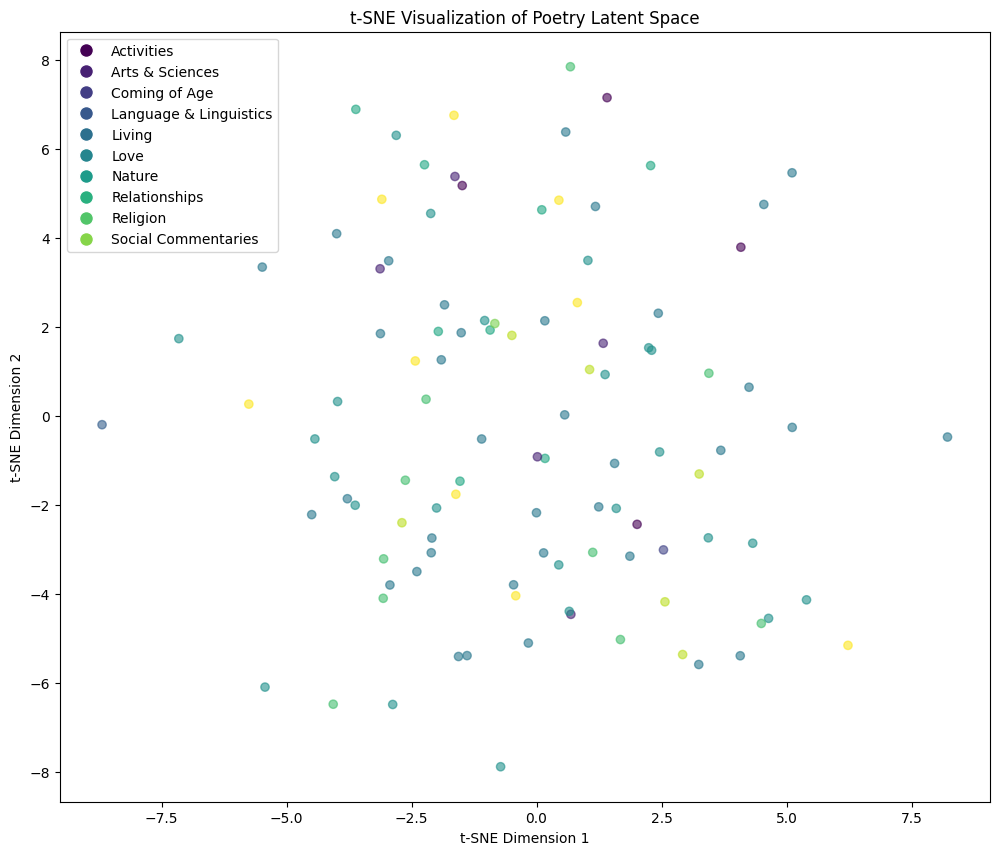

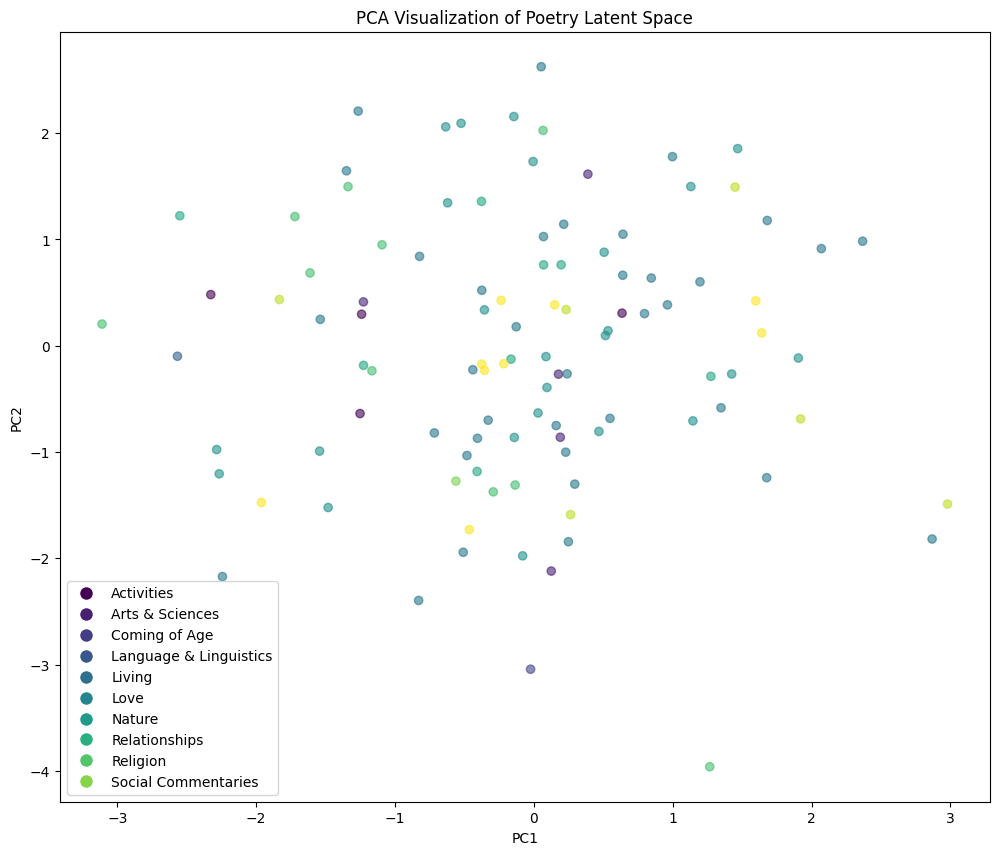

<Figure size 1200x1000 with 0 Axes>

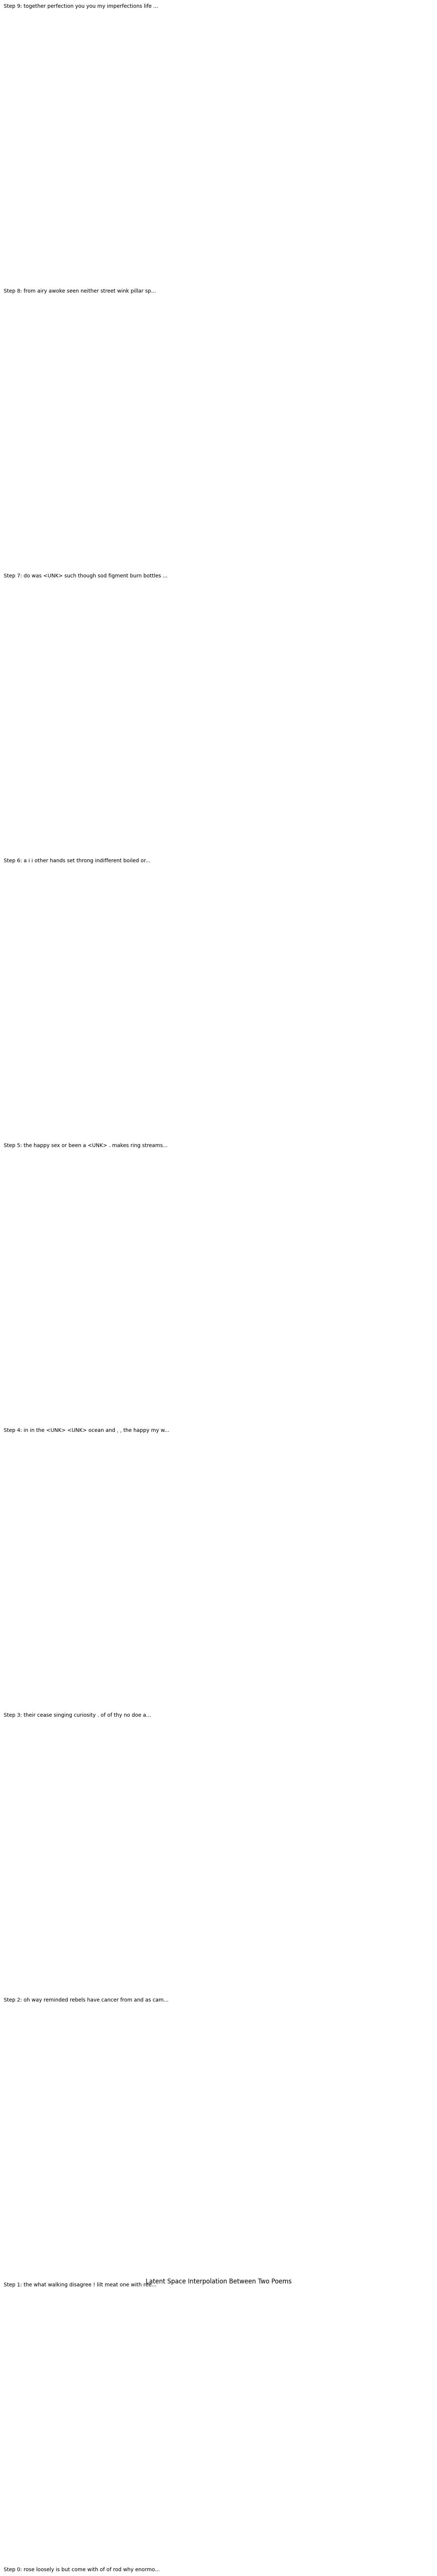

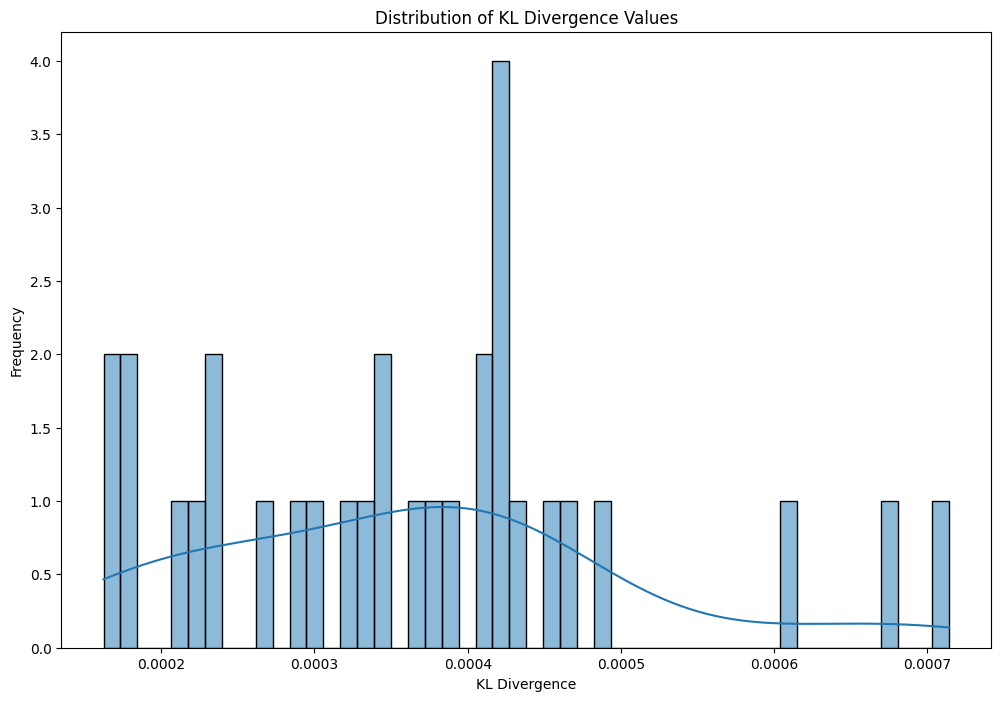

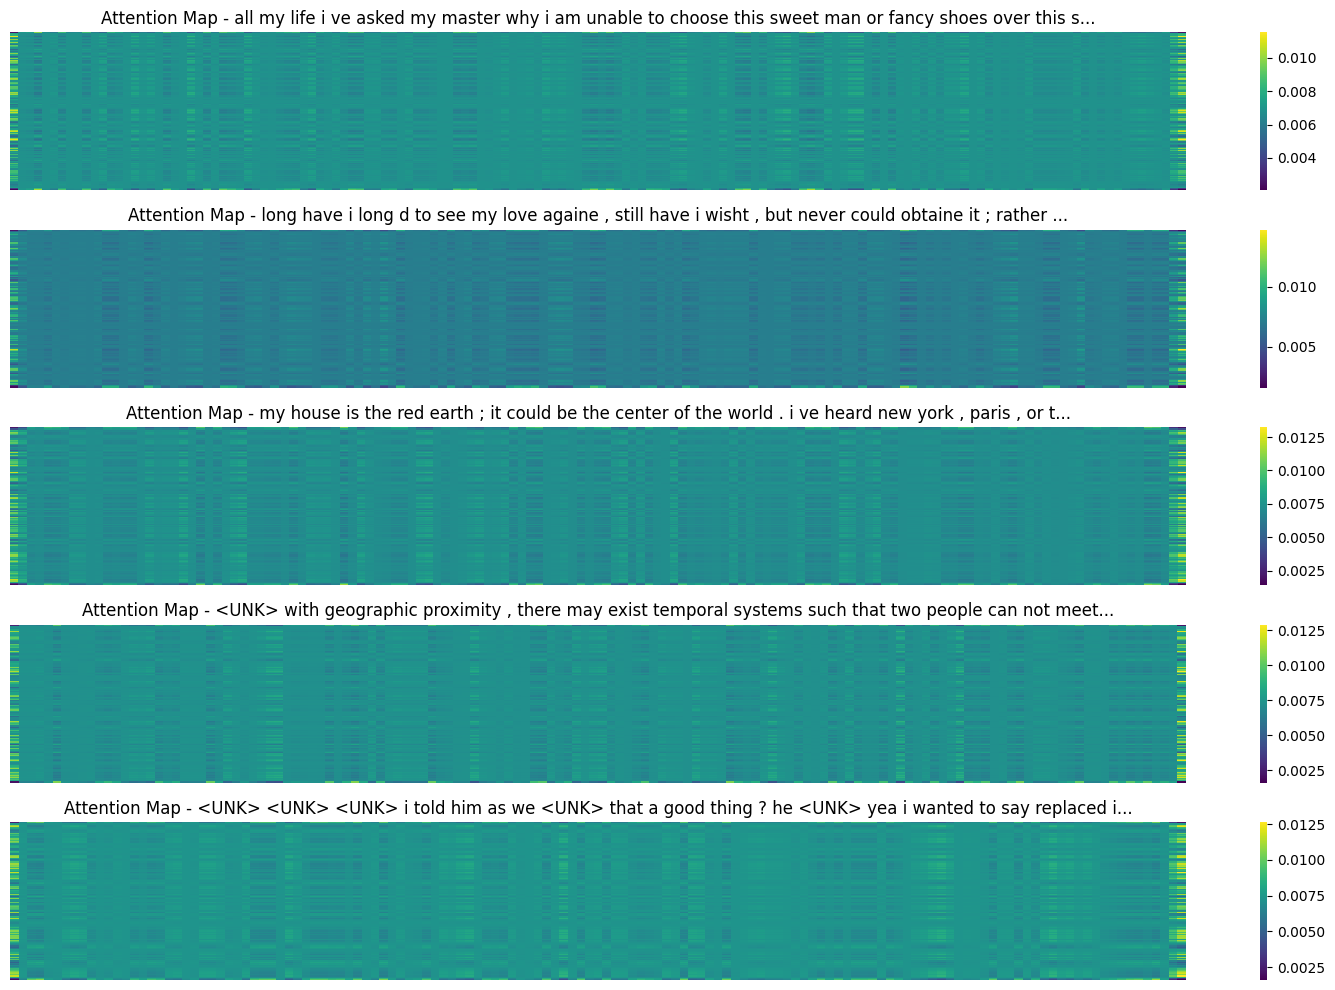

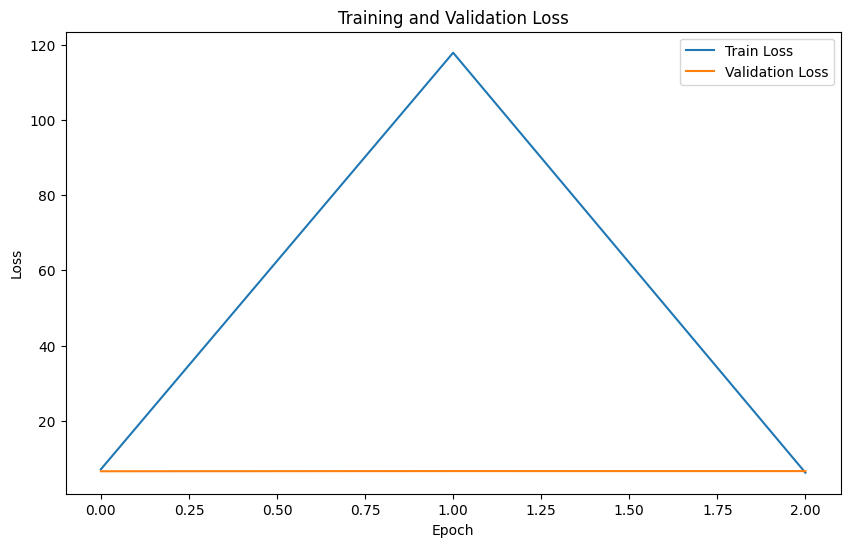

In [ ]:
def main():
    # Create directories
    create_directories()

    # Download and prepare dataset
    print("Downloading dataset...")
    dataset_path = download_dataset()
    extract_dataset(dataset_path)

    # Load and preprocess data
    print("Loading and preprocessing data...")
    poetry_data = load_poetry_data()
    processed_data = prepare_data(poetry_data)

    # Create datasets and dataloaders
    train_dataset = PoetryDataset(processed_data['train_poems'], processed_data['train_meta'])
    val_dataset = PoetryDataset(processed_data['val_poems'], processed_data['val_meta'])
    test_dataset = PoetryDataset(processed_data['test_poems'], processed_data['test_meta'])

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )

    # Initialize model
    print("Initializing model...")
    model = PoetryVAE(
        vocab_size=processed_data['vocab_size'],
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        latent_dim=LATENT_DIM,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ).to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training loop
    print("Starting training...")
    patience = 3
    patience_counter = 0
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Train
        beta = get_kl_beta(epoch, EPOCHS, max_beta=1.0, start_beta=0.0, anneal_epochs=10)
        train_metrics = train_epoch(
            model,
            train_loader,
            optimizer,
            beta=beta,
            teacher_forcing_ratio=TEACHER_FORCING_RATIO
        )

        # Validate
        val_metrics = validate(model, val_loader, beta=beta)

        # Print metrics
        print(f"Train Loss: {train_metrics['loss']:.4f}")
        print(f"Train Perplexity: {train_metrics['perplexity']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val Perplexity: {val_metrics['perplexity']:.4f}")

        # Save best model
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_metrics['loss'],
                'val_loss': val_metrics['loss'],
            }, 'models/best_model.pt')
            print("Saved best model!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

        # Store losses for plotting
        train_losses.append(train_metrics['loss'])
        val_losses.append(val_metrics['loss'])

        # Generate sample poems
        if (epoch + 1) % 1 == 0:  # Generate samples every 5 epochs
            print("\nGenerating sample poems...")
            samples = generate_poems(model, processed_data['idx2word'], num_samples=3)
            for i, poem in enumerate(samples):
                print(f"\nSample {i+1}:")
                print(poem)

    # Final evaluation on test set
    print("\nEvaluating on test set...")
    test_metrics = validate(model, test_loader, beta=BETA)
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Perplexity: {test_metrics['perplexity']:.4f}")

    # Visualize results
    print("\nGenerating visualizations...")
    visualize_latent_space(model, test_loader, processed_data['idx2word'])

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('visualizations/training_curves.png', dpi=300, bbox_inches='tight')

    print("\nTraining completed!")

if __name__ == "__main__":
    main()